In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')


In [60]:
summ = pd.read_csv('summtab.csv')

# Superorbital Characterization
- sometimes there seem to be distinct categories, but better to identify features and sources can have multiple
    - still worth singling out a couple categories that really seem alike and apart from the others
- see document with by-eye categorization to help quantify features

# color-mag slope when bright vs. faint
- divide I range in two and fit line
- is one clearly steeper than the other?
- can also try comparing correlation coefficients


In [70]:
def div_cm(srcn,interp=[],vband=[],frac=0.5,plot=False,findcorr=False):
    '''Divide color mag by middle of Iint range and fit separately.
    specify fraction of range from faintest point to include in faint piece'''
    #get LCs within function 
    if len(interp)==0:
        iband, vband = o.getIV(srcn,cross,stack=True)
        interp = o.colormag(iband,vband,plot=False)
    #add interpolated I to V table
    vband['I int'] = interp
    #divide into two using interp range
    irange = np.max(interp)-np.min(interp)
    split = np.max(interp) - irange*frac
    #lower interp
    vbright = vband[vband['I int']<=split]
    vfaint = vband[vband['I int']>=split]
    #bright half linear best fit
    bmod = np.polyfit(vbright['V mag'] - vbright['I int'],vbright['I int'],1)
    blinmod = (vbright['V mag'] - vbright['I int'])*bmod[0]+bmod[1]
    #faint part
    fmod = np.polyfit(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],1)
    flinmod = (vfaint['V mag'] - vfaint['I int'])*fmod[0]+fmod[1]
    
    if plot: #plot color-mag with two linear best fits
        plt.scatter(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],color='black',s=4)
        plt.scatter(vbright['V mag'] - vbright['I int'],vbright['I int'],color='maroon',s=4)
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.01,mini-.01)
        plt.plot(vfaint['V mag'] - vfaint['I int'],flinmod)
        plt.plot(vbright['V mag'] - vbright['I int'],blinmod)
    if not findcorr:
        if np.abs(fmod[0])>np.abs(bmod[0]): print('steeper when fainter')
        elif np.abs(fmod[0])<np.abs(bmod[0]): print('steeper when brighter')
        #returns faint then bright slope
        return fmod[0],bmod[0]
    #find correlation coefficients as another check
    else:
        fcorr = np.corrcoef(vfaint['V mag']-vfaint['I int'],vfaint['I int'])[1][0]
        bcorr = np.corrcoef(vbright['V mag']-vbright['I int'],vbright['I int'])[1][0]
        return (fcorr**2,fmod[0]),(bcorr**2,bmod[0])

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777


((0.5565777219184822, -0.7817142502368777),
 (0.923357633786783, -2.1097143664210405))

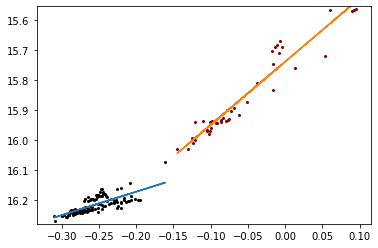

In [58]:
# comparison of correlation coefficients works well only if fraction low, etc.
div_cm(55,plot=True,frac=0.3,findcorr=True)

#### for all sources in first category; don't use $r^2$

In [65]:
summ[summ['src_n']==126]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
99,126,15.482882,-72.174416,0.0,0.86,0.0,1.249876,NaN,15.085534,0.28682,...,NaN,NaN,NaN,-1.446752,0.355912,-3.972394,17.552638,46.048188,2.0,0.153


In [81]:
for s in [55,15,48]: #the other ones are part 2; can do later
    print(div_cm(s,plot=False,frac=0.3))

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
steeper when brighter
(-0.7817142502368777, -2.1097143664210405)
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
steeper when brighter
(-1.414901384568145, -1.721822626558221)
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
steeper when brighter
(-0.5373189569373191, -2.071339432112716)


In [73]:
nums = cross['src_n']

In [82]:
#now for a few sources not in the group
for s in nums[:5]: #the other ones are part 2; can do later
    print(div_cm(s,plot=False,frac=0.3))

I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401
steeper when brighter
(-1.8726433827108229, -2.785861846153874)
I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642
steeper when fainter
(-1.7351281369546334, -1.37878276183988)
I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744
steeper when fainter
(-0.9113626805486055, -0.40648367934272983)
I and V-I correlation: -0.6677821537439047
V and V-I correlation: 0.17975703286765632
steeper when brighter
(-0.10783272462329767, -0.6362910453747979)
I and V-I correlation: -0.7854401757019701
V and V-I correlation: -0.44726007362846626
steeper when brighter
(-0.5788820480420496, -2.5619734890500827)


can be used as one needed characteristic for this category but not going to distinguish being in/out of the group

# is there a base state?
- try to make three categories: 'normal' state at brightest, at faintest, and no 'normal' state (continuous variation)

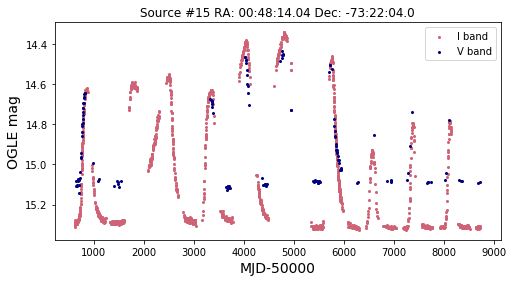

In [109]:
#how many points within some range from brightest vs. faintest point
#maybe check that they occur in every epoch?
iband,vband = o.getIV(15,cross,stack=True,plot=True)

In [112]:
scipy.stats.iqr(iband['I mag'], rng=[50,90])

0.12200000000000166

In [123]:
def findbase(srcn,iband=[],vband=[],plot=True,cut=100,diff=0.1,frac=False,printall=False,perc=0,checkog=True):
    '''percentile used instead of maximum and minimum; must be greater than 50
    if frac: use diff as fraction of range rather than magnitudes
    checkog: check that base points are in all OGLE epochs '''
    if len(iband)==0:
        ilist,vlist = o.getIV(srcn,cross,stack=False,plot=plot)
        iband,vband = vstack(ilist),vstack(vlist)
    #identify minimum and maximum points
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if frac:
        #window for points near max or min is fraction of range
        #if overall low variability, window smaller
        diff = (maxi-mini)*diff
    if perc>0:
        maxi = np.median(iband['I mag'])+scipy.stats.iqr(iband['I mag'], rng=[50,perc])
        mini = np.median(iband['I mag'])-scipy.stats.iqr(iband['I mag'], rng=[(100-perc),50])
    #filter table to points within 0.1 mags (to do: or do fractional?) of max and min
    minf = iband[iband['I mag']<=mini+diff]
    maxf = iband[iband['I mag']>=maxi-diff]
    
    if len(maxf)>len(minf)+cut:
        #make sure maximum points exist in all OGLE epochs
        go = True
        if checkog: 
            for i in ilist:
                tmaxf = i[i['I mag']>=maxi-diff]
                #in no points in an epoch, sets to undetermined
                if len(tmaxf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at faintest')
            else: plt.text(6500,mini+(maxi-mini)/2,'base at faintest')
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            else: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
    elif len(minf)>len(maxf)+cut:
        go = True
        if checkog: 
            for i in ilist:
                tminf = i[i['I mag']<=mini+diff]
                #in no points in an epoch, sets to undetermined
                if len(tminf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at brightest')
            else: plt.text(6500,mini+(maxi-mini)/2,'base at brightest')
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            else: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
    else: 
        if printall: print(f'{srcn}: undetermined or no base')
        else: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')

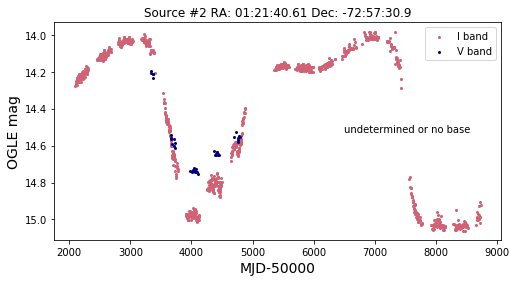

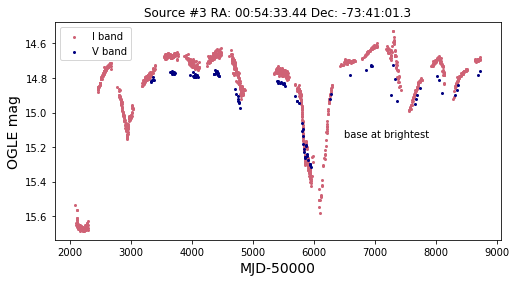

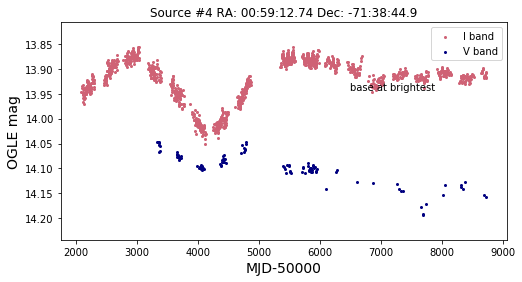

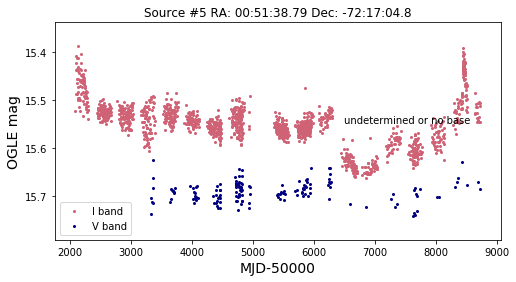

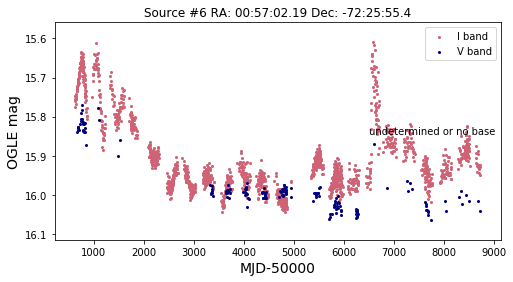

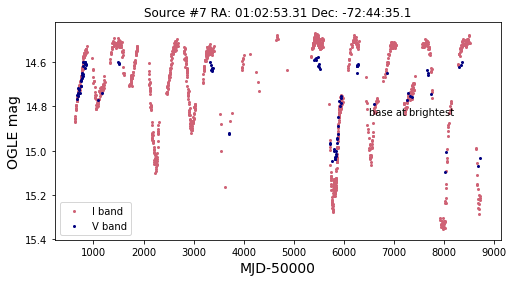

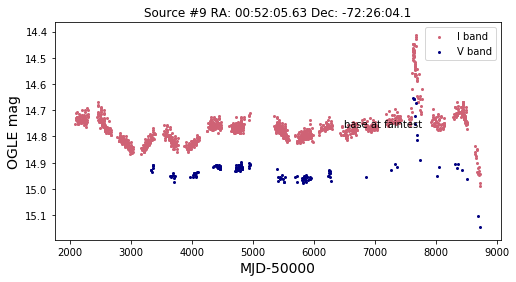

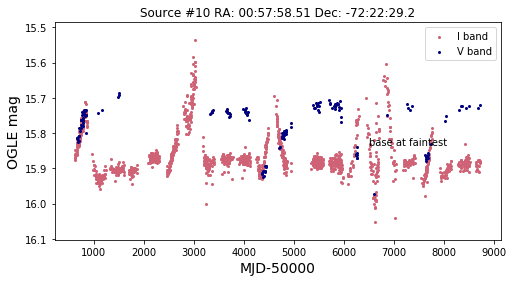

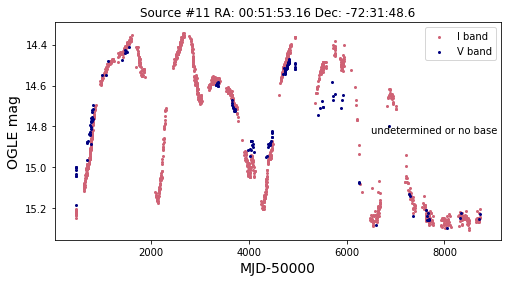

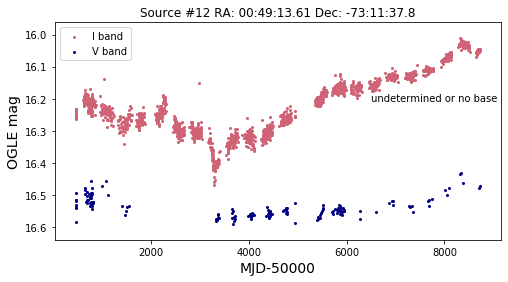

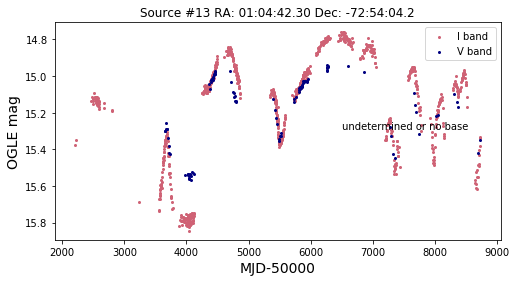

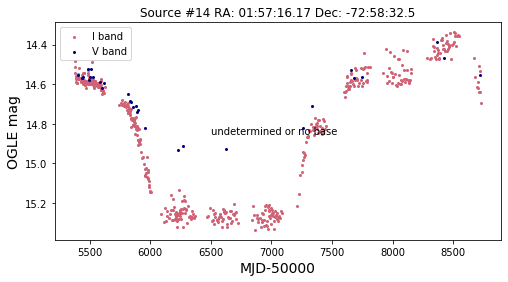

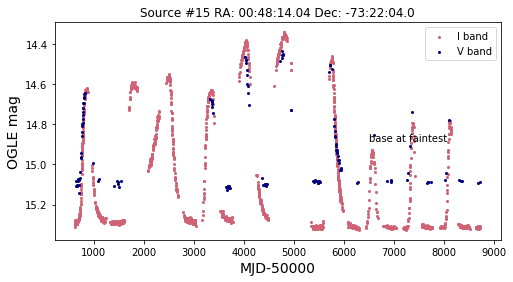

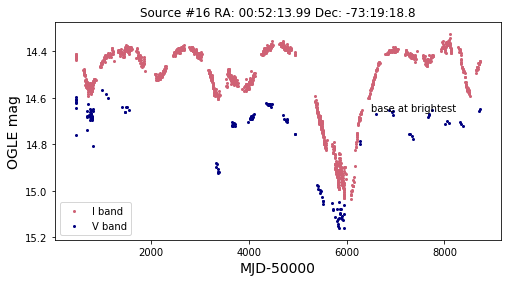

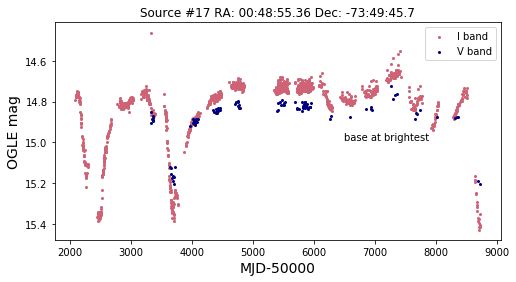

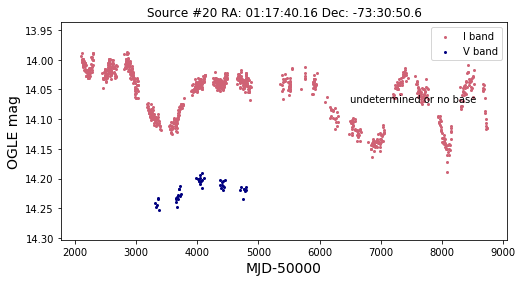

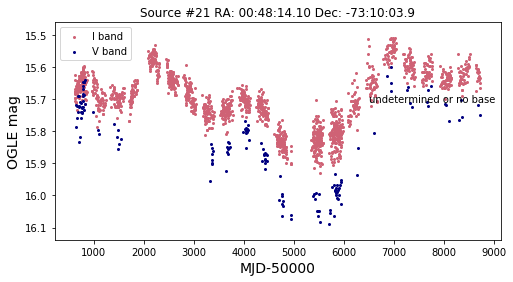

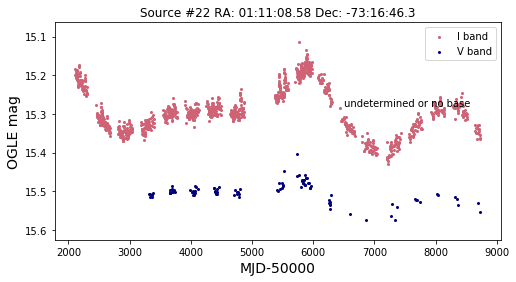

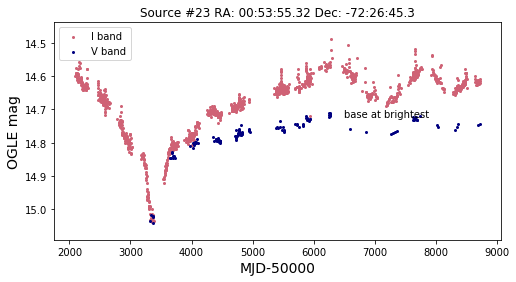

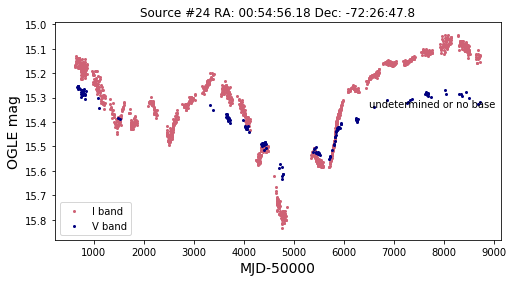

In [126]:
#happy with basically all of these
for s in nums[:20]:
    findbase(s,perc=95,cut=200,frac=True)

perhaps the max/min that 'fails' the test needs to be distributed in all epochs s.t. a very long-term trend doesn't justify a base determination

empty file for OIII I


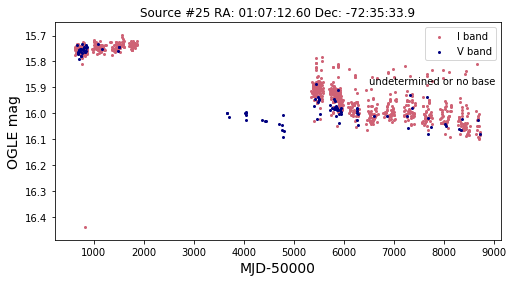

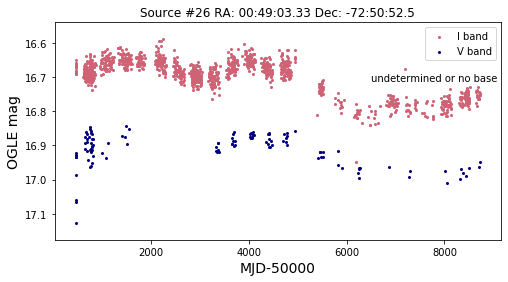

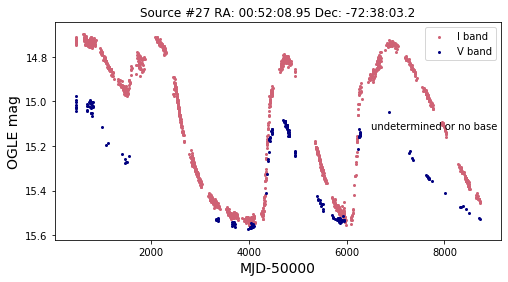

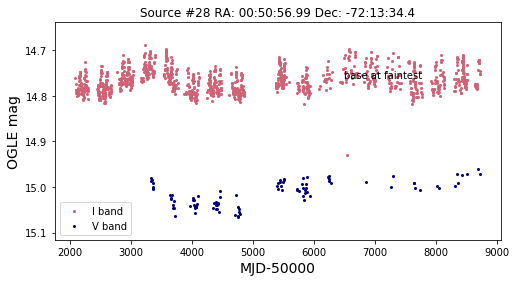

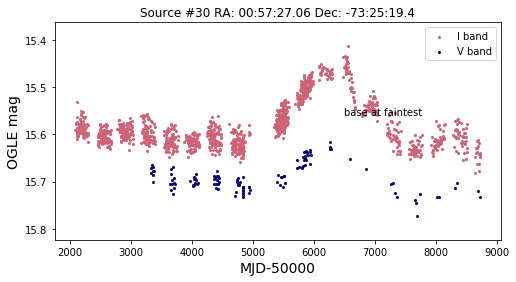

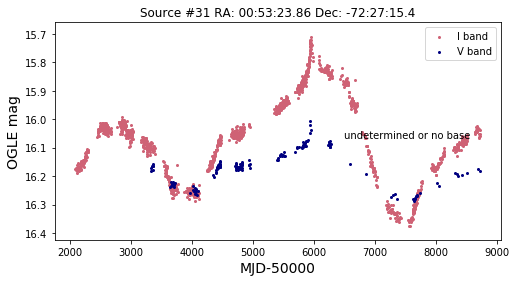

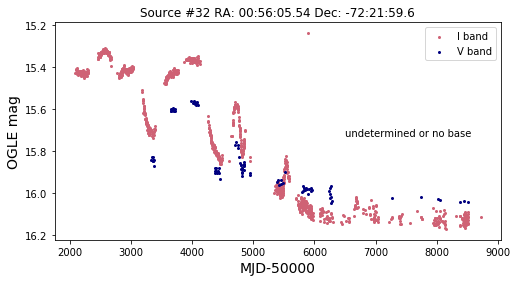

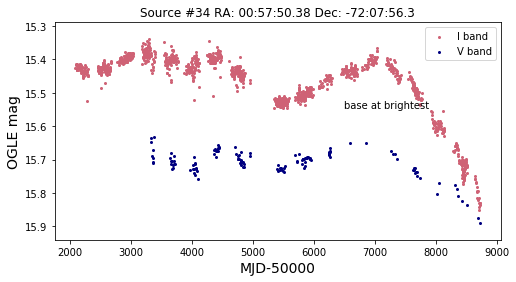

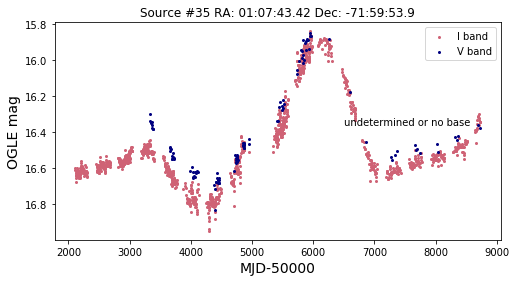

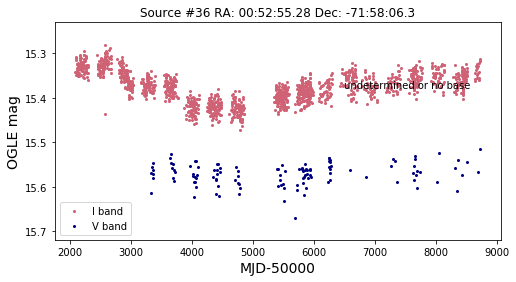

In [125]:
for s in nums[20:30]:
    findbase(s,perc=95,cut=200,frac=True,checkog=True)

# shape of flare
- compare width to height
- triangular?
    - width within some fraction of flare?
- **as a side task, work on also getting peak width of periodogram**

In [371]:
iband,vband = o.getIV(15,cross,stack=True,plot=False)

In [369]:
def peaks(iband,bright=True,window=100,btol=100,height=0.1,distance=30,plot=True,frac=0.3):
    '''Use spline to find peaks (or troughs) in I band data
    bright: (bool) look for brightness peaks (so magnitude minima)
    TO DO: generalize to troughs'''
    flatten,trend = o.splinedetrend(iband,window=window,btol=btol,retspline=True)
    if bright: diff = np.max(trend) - trend
    else: diff = trend
    peaks = signal.find_peaks(diff,height=height,distance=distance) 
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if plot:
        plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=3)
        plt.ylim(maxi+.01,mini-.01)
    peakmag = iband['I mag'][peaks[0]]
    cut = maxi-(maxi-mini)*frac
    inds = np.where(peakmag<cut)[0]
    minpeaks = peakmag[inds]
    minloc = peaks[0][inds]
    if plot:
        plt.scatter(iband['MJD-50000'][peaks[0]],iband['I mag'][peaks[0]],label='deleted peaks')
        plt.scatter(iband['MJD-50000'][minloc],minpeaks,color='darkseagreen',label='kept peaks')
        plt.plot(iband['MJD-50000'],trend,color='black',alpha=0.3,label='spline')
        plt.legend()
    #decide what to return
    return trend,minloc #returns indices in iband of peaks

array([ 143,  315,  425,  668,  792,  946, 1112, 1348, 1460, 1569])

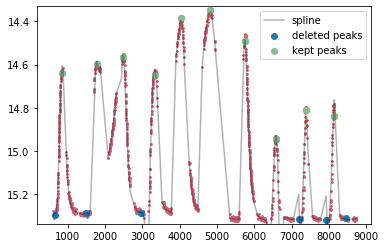

In [372]:
trend,minloc = peaks(iband)
minloc

#### peak widths
 - peak heights are not a reliable help

calculate peak heights using 95th percentile of window between peaks

In [387]:
def peakwidth(iband,trend,pinds,frac=0.5,bounds=False,plot=True,retheight=True,fs=(5,4),text=False,split=0.7,spline=False,wmin=50):
    '''find width of peak at some fraction of range (default: FWHM)
    bounds of peak can be passed in or found using...
    pinds: indices of peaks in iband
    bounds: (bool) use pinds as start and end dates of peaks rather than locs of peaks
    retheight: return height of peak as well'''
    #if bounds, pinds are start and end dates of peak
    if bounds:
        df = iband[iband['MJD-50000']>=pinds[0]]
        df = iband[iband['MJD-50000']<=pinds[1]]
    else:
        plocs = np.array(iband['MJD-50000'][pinds])
        df = iband[iband['MJD-50000']<plocs[0]+(plocs[1]-plocs[0])*split]
        len1 = len(df)
        df = df[df['MJD-50000']>plocs[0]-(plocs[1]-plocs[0])/2]
        len2 = len(df)
    if plot: 
        plt.figure(figsize=fs)
        plt.scatter(df['MJD-50000'],df['I mag'],color=pink)
        maxi,mini = np.max(df['I mag']),np.min(df['I mag'])
        plt.ylim(maxi+.02,mini-.02)
    #start ind 
    st = len1-len2
    end = len(df)+st
    half = np.min(df['I mag']) + (np.max(df['I mag']) - np.min(df['I mag']))*frac
    if plot:
        if spline: plt.plot(df['MJD-50000'],trend[st:end],color=pink)
        #draw line at half max or other fraction of range
        plt.axhline(half,color='grey')
    #interpolate spline for even coverage
    x = np.arange(df['MJD-50000'][0],df['MJD-50000'][-1])
    if spline: interp = np.interp(x,df['MJD-50000'],trend[st:end])
    else: interp = np.interp(x,df['MJD-50000'],df['I mag'])
    #find intersection of line and interpolated spline
    idx = np.argwhere(np.diff(np.sign(interp - half))).flatten()
    width = x[idx[1]]-x[idx[0]]
    #replace width if multple points before other side
    c = 2
    while width<50:
        width = x[idx[c]]-x[idx[0]]
        c+=1
    if plot: 
        plt.scatter(x[idx], interp[idx], color='darkseagreen')
        lenx = len(x)
        if text: plt.text(x[idx[0]],np.max(iband['I mag'])-.04,f'width at {frac} of peak: {width:.2f} days')
        plt.ylabel('I mag',fontsize=14)
        plt.xlabel('MJD-50000',fontsize=14)
    height = np.max(df['I mag'])-np.min(df['I mag'])
    if retheight: return width,height
    else: return width

In [385]:
def allwidths(iband,trend,pinds,frac=0.5,bounds=False,plot=True,retheight=True):
    '''loop through all peaks and calculate widths and heights
    TO DO: plot on subplots'''
    widths,heights = [],[]
    #final bound is last point of iband
    end = len(iband)-1
    pinds = np.concatenate([pinds,[end]])
    for p in range(len(pinds)-1):
        #get width and height of peak
        w,h = peakwidth(iband,trend,[pinds[p],pinds[p+1]],frac=0.5,bounds=bounds,plot=plot,retheight=retheight)
        widths.append(w)
        heights.append(h)
    return widths, heights

In [292]:
minloc

array([ 143,  315,  425,  668,  792,  946, 1112, 1348, 1460, 1569])

[188.0,
 375.0,
 414.0,
 230.0,
 334.99999999999955,
 539.0,
 194.0,
 126.0,
 104.0,
 132.0]

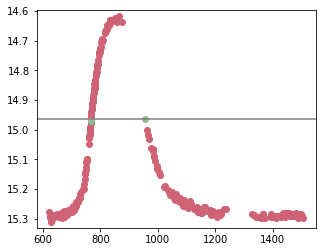

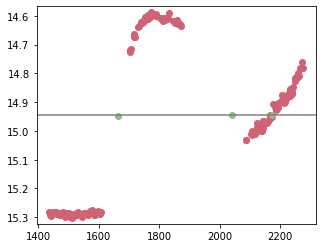

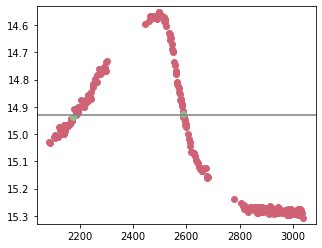

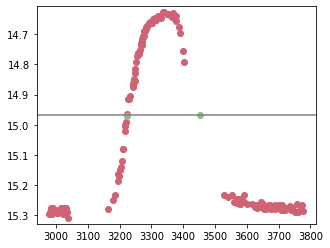

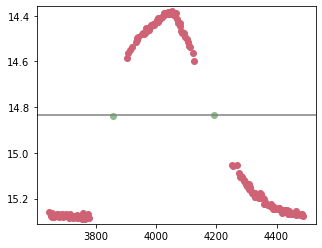

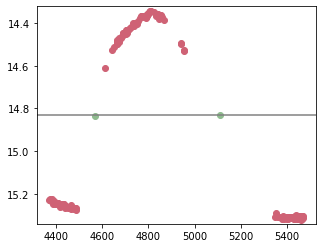

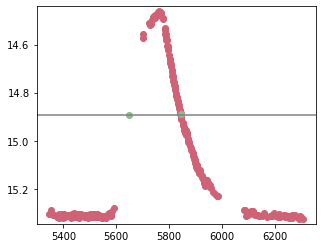

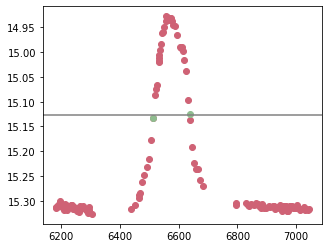

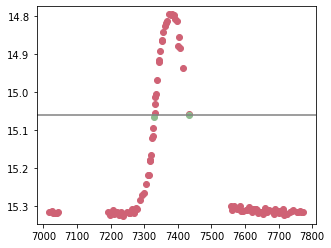

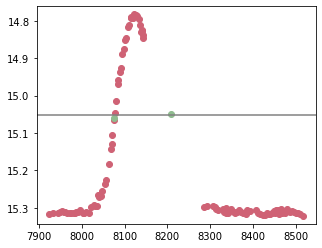

In [358]:
ws,hs = allwidths(iband,trend,minloc)
ws

In [362]:
#variation of peak distances -- compare these to widths
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
seps

array([925.17414, 702.15882, 843.66484, 707.11579, 787.95173, 919.30032,
       837.72239, 807.90837, 751.9861 ])

Text(0.5, 0, 'Peak Width (days)')

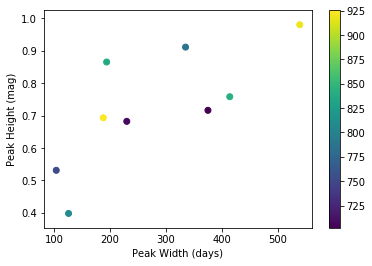

In [367]:
#relationship between FWHM and height
#color is distance between flare peak and previous flare peak
plt.scatter(ws[:-1],hs[:-1],c=seps)
plt.colorbar()
plt.ylabel('Peak Height (mag)')
plt.xlabel('Peak Width (days)')

goals with flare shape
- make similar plots to one above
- help with categorization
    - e.g. use ratio of width and height

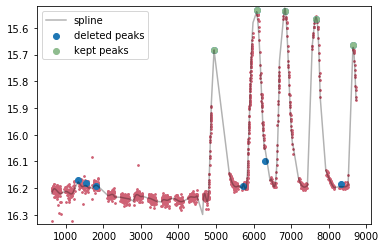

In [373]:
#repeat for others of this type
iband,vband = o.getIV(55,cross,stack=True,plot=False)
trend,minloc = peaks(iband)

In [388]:
ws,hs = allwidths(iband,trend,minloc[:-1],plot=False) #couldn't do final flare since it doesn't reach half max

In [389]:
ws

[351.0, 308.0, 298.0, 277.0]

In [390]:
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
seps

array([1135.99572,  746.00591,  832.80413,  988.21437])

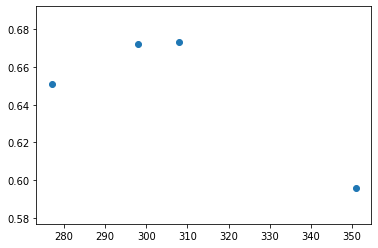

In [391]:
plt.scatter(ws,hs) #interesting but tough when sampling so uneven in first peak

Text(0.5, 0, 'Widths')

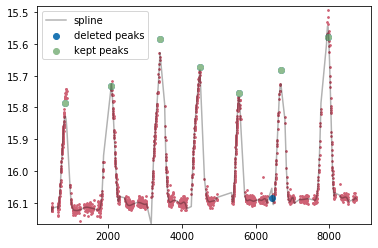

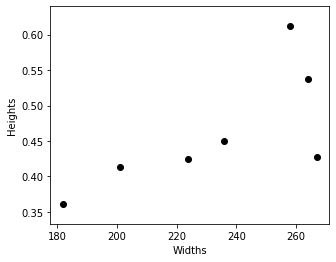

In [394]:
iband,vband = o.getIV(48,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')

others can be added once part 2 sources loaded in

Text(0.5, 0, 'Widths')

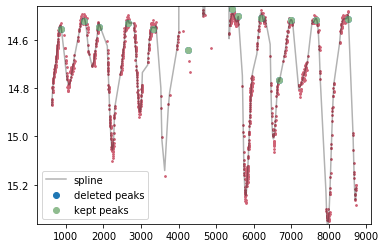

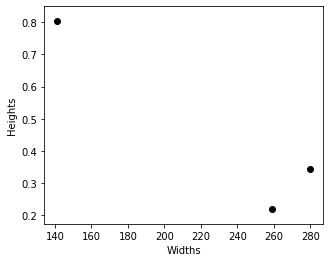

In [402]:
#try on other source
iband,vband = o.getIV(7,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
#error for a flare after this
ws,hs = allwidths(iband,trend,minloc[:3],plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')

Text(0.5, 0, 'Widths')

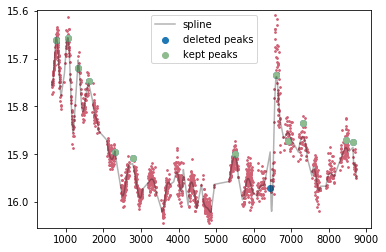

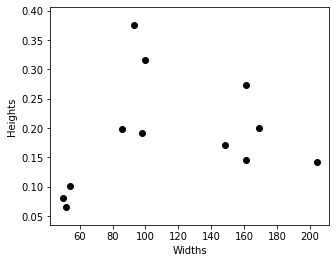

In [403]:
#try on other source
iband,vband = o.getIV(6,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
#error for a flare after this
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')

but these steps can easily fail
- maybe can play with parameters, but wouldn't run it automatically

# loops/multiple V-I for single I 
- connection to certain features?

# continuous amplitude change
- range decreasing or increasing
    - but still need to section off the peaks

# look for periodicity in obvious type

# look for difference in orbital during big dips